# 📊 LLM OptiBench — Benchmark Results Explorer

This notebook provides a comprehensive EDA of the benchmark results produced by the OptiBench pipeline.
It covers accuracy analysis, performance profiling, memory efficiency, and trade-off visualizations.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np
import os, glob
from math import pi

# ── Style ────────────────────────────────────────────────────────────────
sns.set_theme(style="darkgrid", palette="deep", font_scale=1.1)
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titleweight": "bold",
    "axes.titlesize": 13,
})

RUN_COLORS = {
    "Baseline (FP16)": "#3b82f6",
    "Quantized (4-bit NF4)": "#22c55e",
    "Pruned (Unstructured)": "#eab308",
    "Hybrid (Quant + Prune)": "#ef4444",
}

---
## 1 · Load Data

In [9]:
results_dir = "../results"
csv_files = sorted(glob.glob(os.path.join(results_dir, "benchmark_report_*.csv")))

if not csv_files:
    raise FileNotFoundError("No benchmark reports found in ../results/")

latest = csv_files[-1]
print(f"📄 Loading: {latest}")
df = pd.read_csv(latest)
df

📄 Loading: ../results/benchmark_report_20260212_141531.csv


,Run Name,F1 Score,Exact Match (EM),Avg Latency (tok/s),Total Time (s),Peak VRAM (GB),Model Size (GB)
0,Baseline (FP16),17.779482,7.0,50.418025,45.620940,2.089916,2.049000
1,Quantized (4-bit NF4),33.484049,29.0,22.586289,68.062293,0.793688,0.695484
2,Pruned (Unstructured),45.171781,39.0,34.464217,22.636858,2.090226,2.049000
3,Hybrid (Quant + Prune),0.000000,0.0,33.197823,151.032490,0.792763,0.695484


---
## 2 · Summary Statistics

In [10]:
summary = df.set_index("Run Name").T
summary.index.name = "Metric"

# Add derived metrics
df["VRAM Savings vs Baseline (%)"] = (
    (1 - df["Peak VRAM (GB)"] / df["Peak VRAM (GB)"].iloc[0]) * 100
).round(1)
df["Size Savings vs Baseline (%)"] = (
    (1 - df["Model Size (GB)"] / df["Model Size (GB)"].iloc[0]) * 100
).round(1)
df["F1 Delta vs Baseline"] = (df["F1 Score"] - df["F1 Score"].iloc[0]).round(2)
df["Speed Ratio vs Baseline"] = (df["Avg Latency (tok/s)"] / df["Avg Latency (tok/s)"].iloc[0]).round(2)

print("\n📋 Derived metrics added.")
df


📋 Derived metrics added.


,Run Name,F1 Score,Exact Match (EM),Avg Latency (tok/s),Total Time (s),Peak VRAM (GB),Model Size (GB),VRAM Savings vs Baseline (%),Size Savings vs Baseline (%),F1 Delta vs Baseline,Speed Ratio vs Baseline
0,Baseline (FP16),17.779482,7.0,50.418025,45.620940,2.089916,2.049000,0.0,0.0,0.00,1.00
1,Quantized (4-bit NF4),33.484049,29.0,22.586289,68.062293,0.793688,0.695484,62.0,66.1,15.70,0.45
2,Pruned (Unstructured),45.171781,39.0,34.464217,22.636858,2.090226,2.049000,-0.0,0.0,27.39,0.68
3,Hybrid (Quant + Prune),0.000000,0.0,33.197823,151.032490,0.792763,0.695484,62.1,66.1,-17.78,0.66


---
## 3 · Core Metric Comparison (Bar Charts)

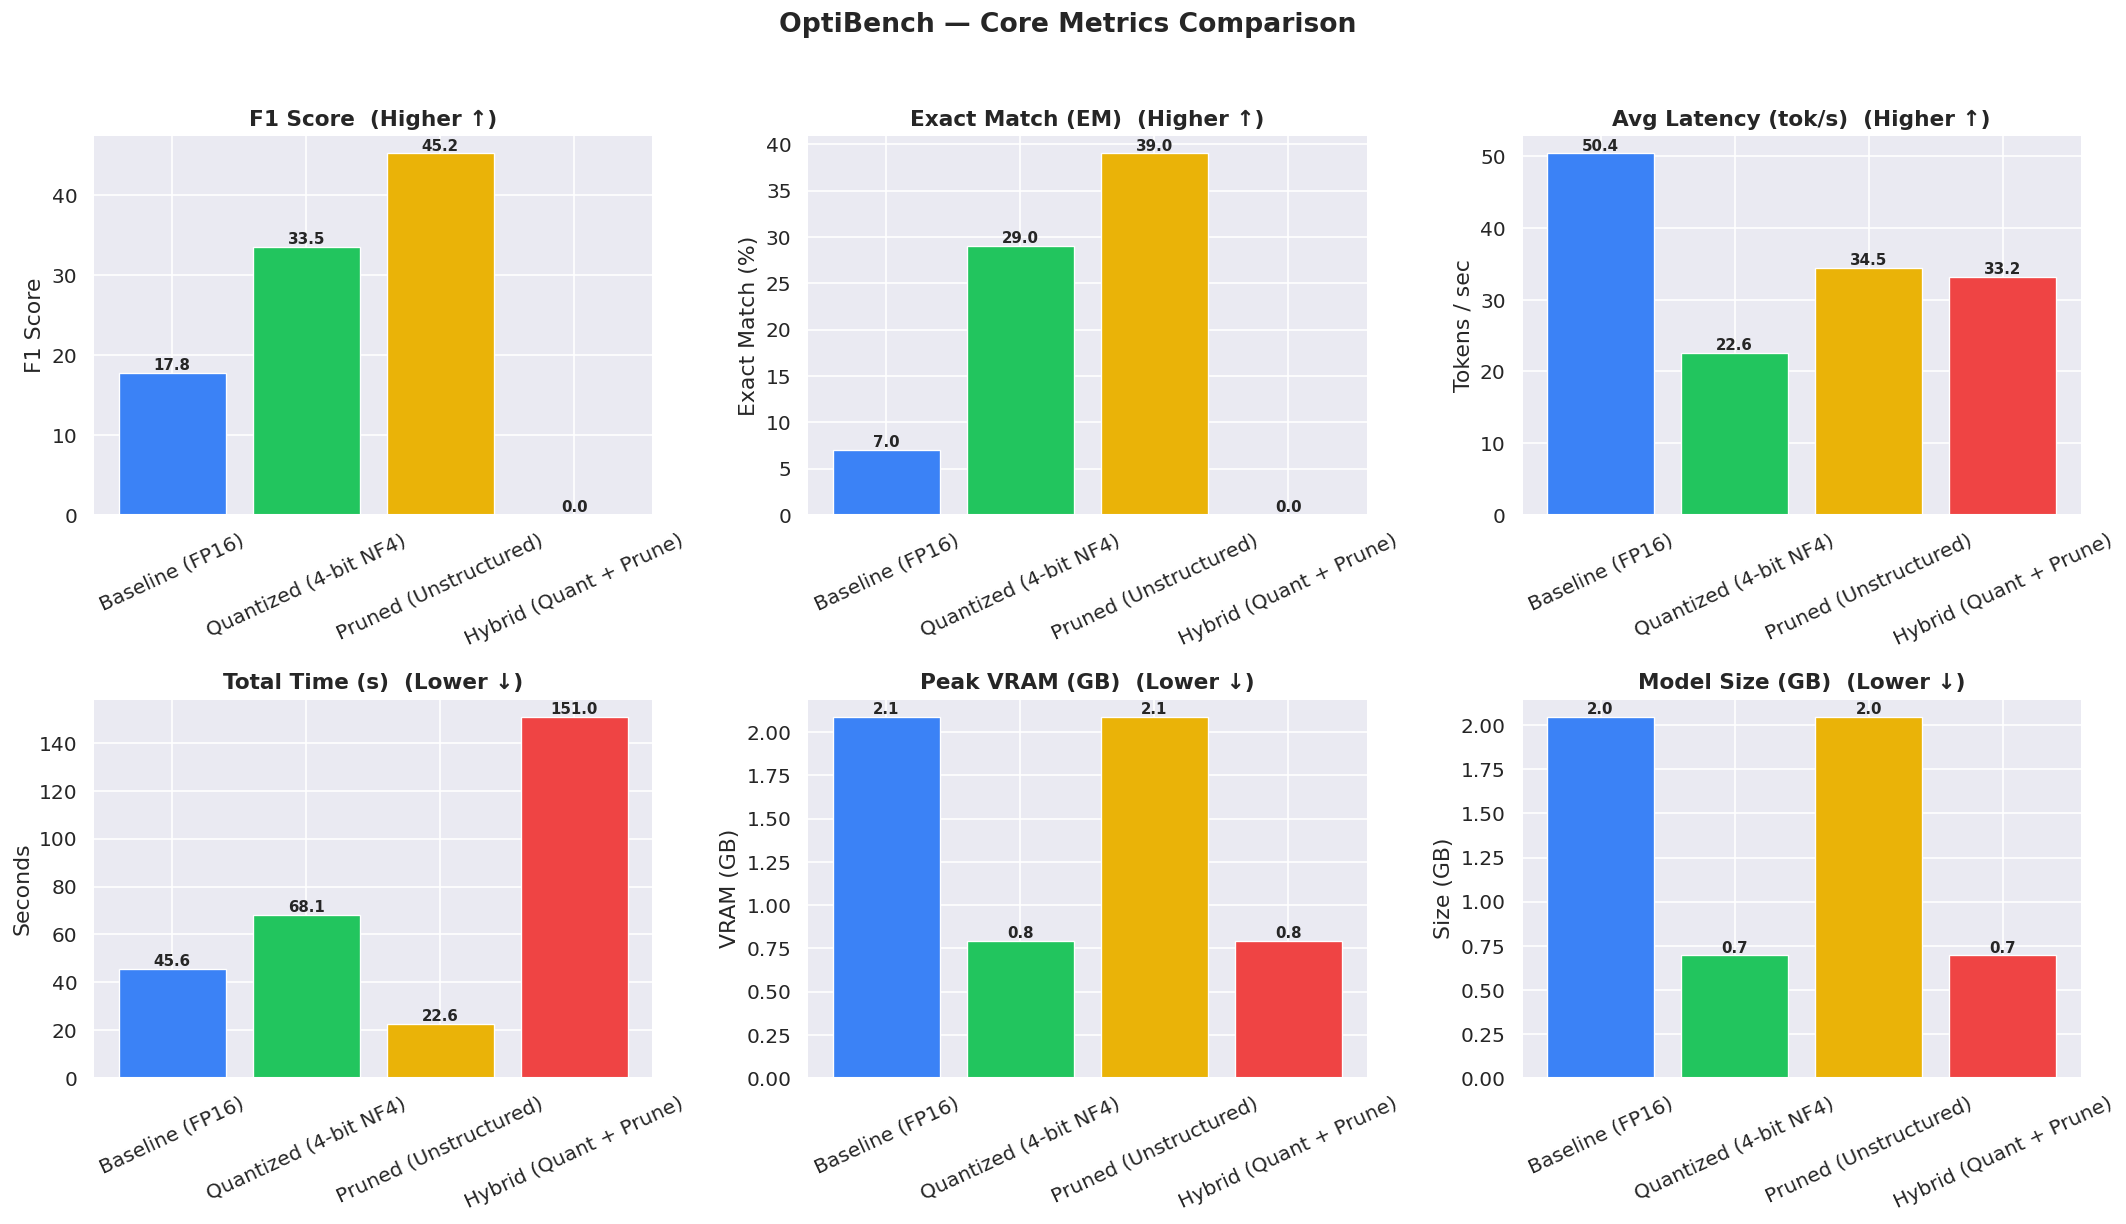

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("OptiBench — Core Metrics Comparison", fontsize=16, fontweight="bold", y=1.02)

metrics = [
    ("F1 Score",            "F1 Score",         "magma",   "Higher ↑"),
    ("Exact Match (EM)",    "Exact Match (%)",  "magma",   "Higher ↑"),
    ("Avg Latency (tok/s)", "Tokens / sec",     "viridis", "Higher ↑"),
    ("Total Time (s)",      "Seconds",          "rocket",  "Lower ↓"),
    ("Peak VRAM (GB)",      "VRAM (GB)",        "mako",    "Lower ↓"),
    ("Model Size (GB)",     "Size (GB)",        "crest",   "Lower ↓"),
]

for ax, (col, ylabel, pal, direction) in zip(axes.flat, metrics):
    colors = [RUN_COLORS.get(r, "#888") for r in df["Run Name"]]
    bars = ax.bar(df["Run Name"], df[col], color=colors, edgecolor="white", linewidth=0.8)
    ax.set_ylabel(ylabel)
    ax.set_title(f"{col}  ({direction})")
    ax.tick_params(axis="x", rotation=25)
    # Value labels
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h, f"{h:.1f}",
                ha="center", va="bottom", fontsize=9, fontweight="bold")

plt.tight_layout()
plt.show()

---
## 4 · Accuracy vs Efficiency Trade-off

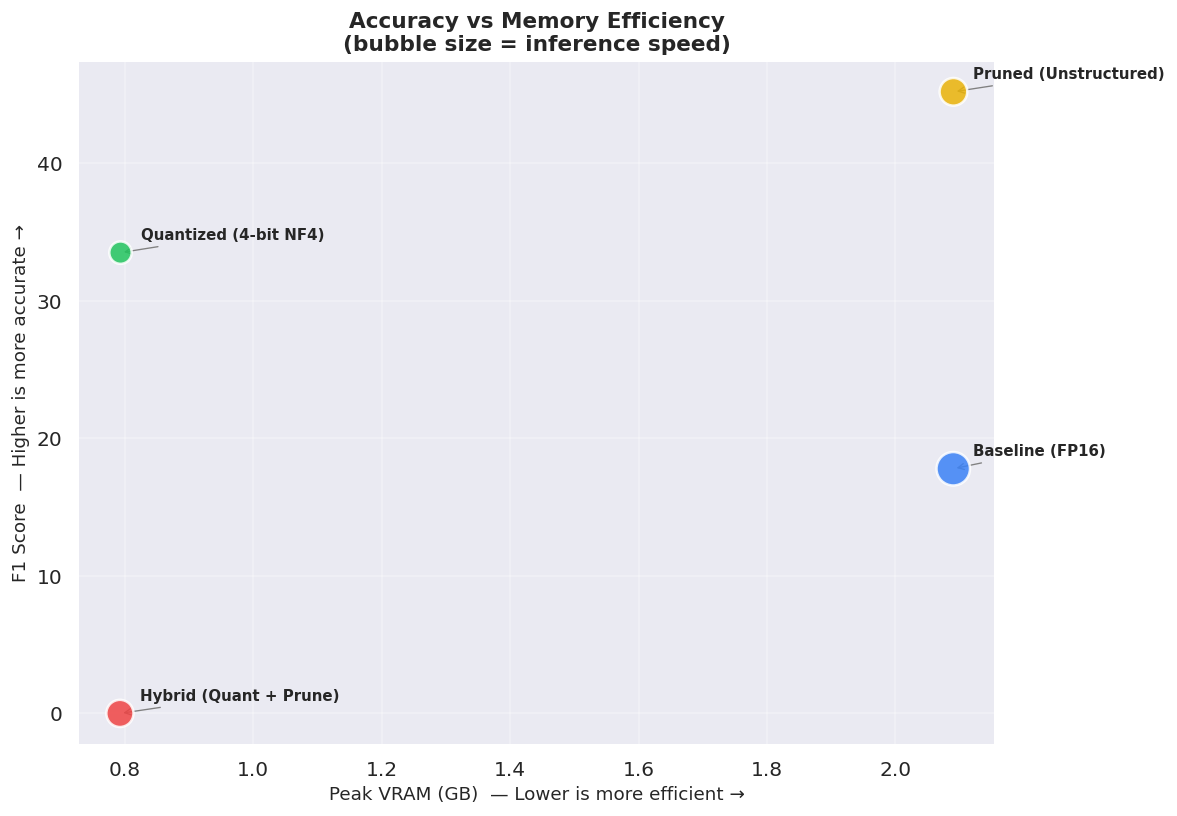

In [12]:
fig, ax = plt.subplots(figsize=(10, 7))

scatter = ax.scatter(
    df["Peak VRAM (GB)"],
    df["F1 Score"],
    s=df["Avg Latency (tok/s)"] * 8,   # bubble size = speed
    c=[RUN_COLORS.get(r, "#888") for r in df["Run Name"]],
    edgecolors="white",
    linewidth=1.5,
    alpha=0.85,
    zorder=5,
)

for _, row in df.iterrows():
    ax.annotate(
        row["Run Name"],
        (row["Peak VRAM (GB)"], row["F1 Score"]),
        textcoords="offset points", xytext=(12, 8),
        fontsize=9, fontweight="bold",
        arrowprops=dict(arrowstyle="->", color="gray", lw=0.8),
    )

ax.set_xlabel("Peak VRAM (GB)  — Lower is more efficient →", fontsize=11)
ax.set_ylabel("F1 Score  — Higher is more accurate →", fontsize=11)
ax.set_title("Accuracy vs Memory Efficiency\n(bubble size = inference speed)", fontsize=13)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 5 · Normalized Radar Chart

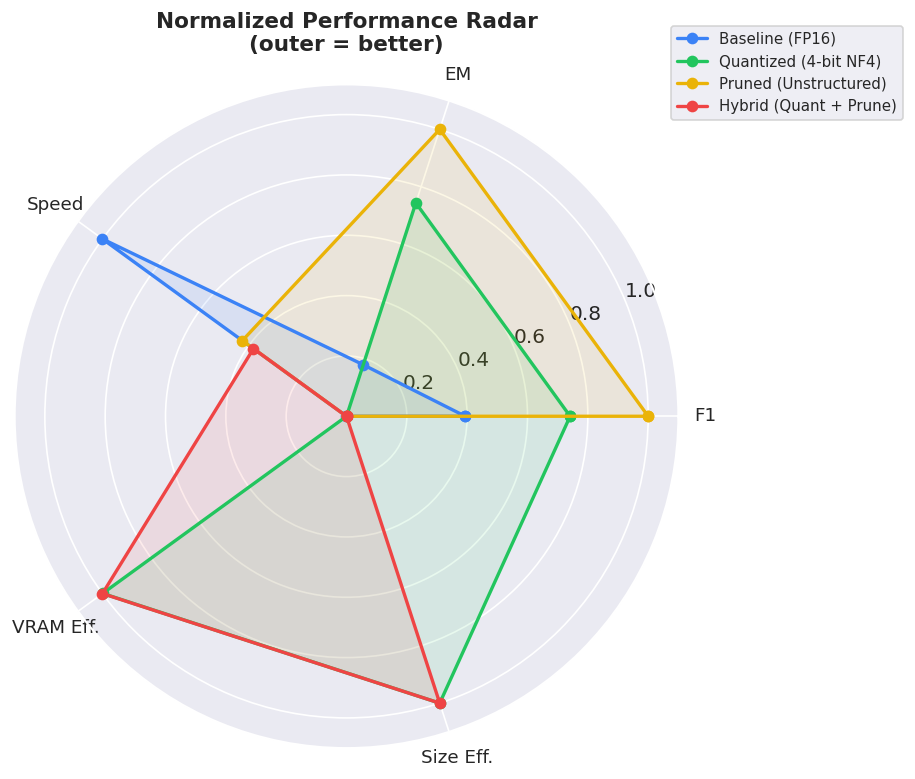

In [13]:
# For radar: normalize each metric to [0, 1].  
# For VRAM & Size, invert so that lower = better = closer to 1.
radar_cols = ["F1 Score", "Exact Match (EM)", "Avg Latency (tok/s)", "Peak VRAM (GB)", "Model Size (GB)"]
invert = ["Peak VRAM (GB)", "Model Size (GB)"]
labels = ["F1", "EM", "Speed", "VRAM Eff.", "Size Eff."]

norm = df[radar_cols].copy()
for c in radar_cols:
    rng = norm[c].max() - norm[c].min()
    if rng == 0:
        norm[c] = 0.5
    else:
        norm[c] = (norm[c] - norm[c].min()) / rng
    if c in invert:
        norm[c] = 1 - norm[c]

N = len(labels)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for idx, row in norm.iterrows():
    vals = row.tolist() + [row.tolist()[0]]
    name = df.loc[idx, "Run Name"]
    color = RUN_COLORS.get(name, "#888")
    ax.plot(angles, vals, "o-", linewidth=2, label=name, color=color)
    ax.fill(angles, vals, alpha=0.1, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylim(0, 1.1)
ax.set_title("Normalized Performance Radar\n(outer = better)", fontsize=13, pad=20)
ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.1), fontsize=9)

plt.tight_layout()
plt.show()

---
## 6 · Savings & Penalties — Waterfall View

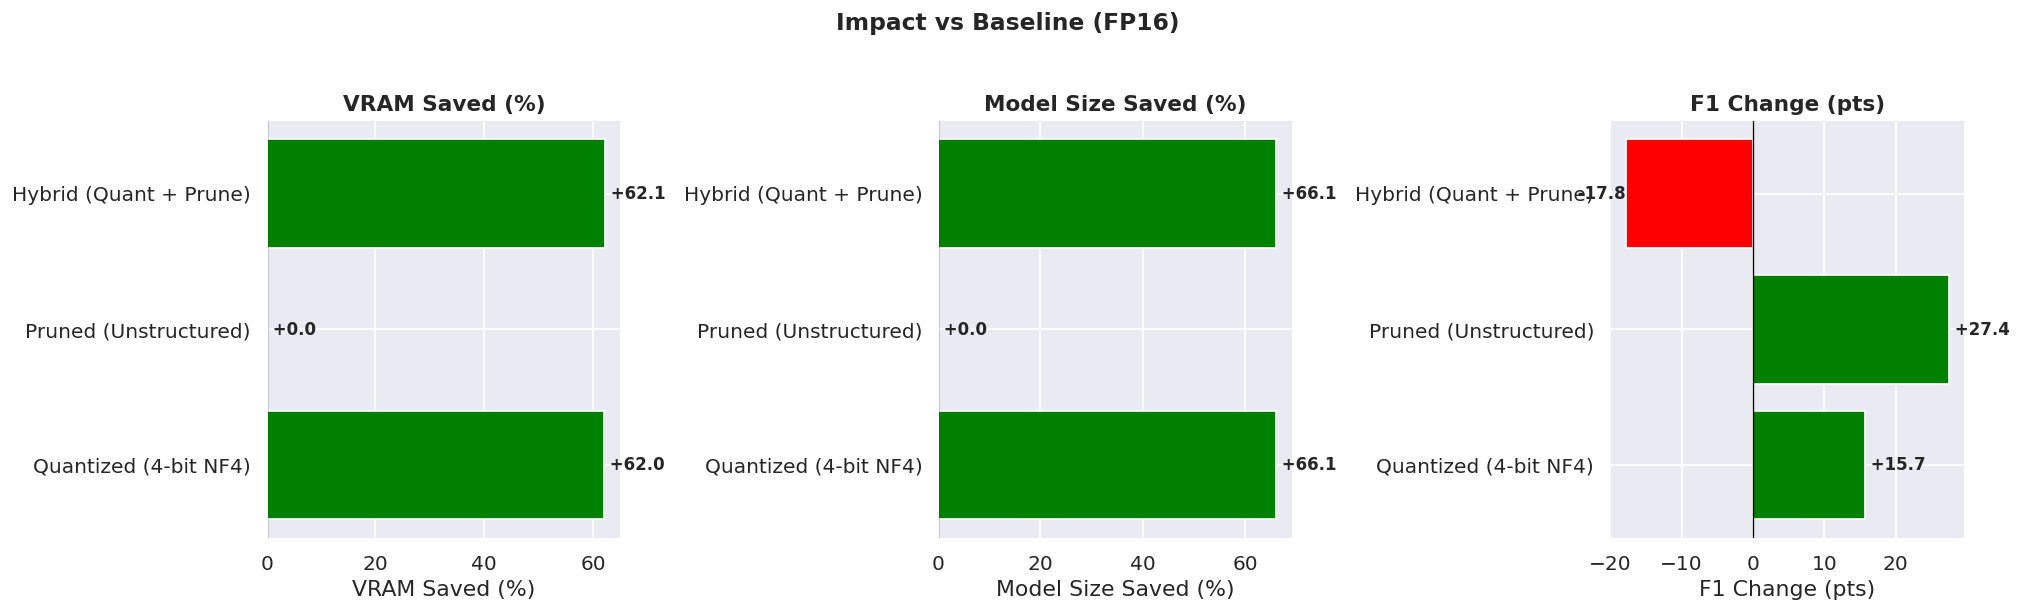

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))
fig.suptitle("Impact vs Baseline (FP16)", fontsize=14, fontweight="bold", y=1.02)

delta_metrics = [
    ("VRAM Savings vs Baseline (%)", "VRAM Saved (%)", "teal"),
    ("Size Savings vs Baseline (%)", "Model Size Saved (%)", "purple"),
    ("F1 Delta vs Baseline",         "F1 Change (pts)", "coral"),
]

for ax, (col, title, color) in zip(axes.flat, delta_metrics):
    non_baseline = df[df["Run Name"] != "Baseline (FP16)"].copy()
    colors_bar = ["green" if v >= 0 else "red" for v in non_baseline[col]]
    bars = ax.barh(non_baseline["Run Name"], non_baseline[col], color=colors_bar, edgecolor="white")
    ax.set_xlabel(title)
    ax.axvline(0, color="black", linewidth=0.8)
    ax.set_title(title)
    for bar in bars:
        w = bar.get_width()
        ax.text(w, bar.get_y() + bar.get_height()/2, f" {w:+.1f}",
                ha="left" if w >= 0 else "right", va="center", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

---
## 7 · Efficiency Score (Composite Ranking)

🏆 Composite Efficiency Ranking (higher = better overall):


,Run Name,Efficiency Score
0,Quantized (4-bit NF4),69.7
1,Pruned (Unstructured),48.5
2,Hybrid (Quant + Prune),47.6
3,Baseline (FP16),35.7


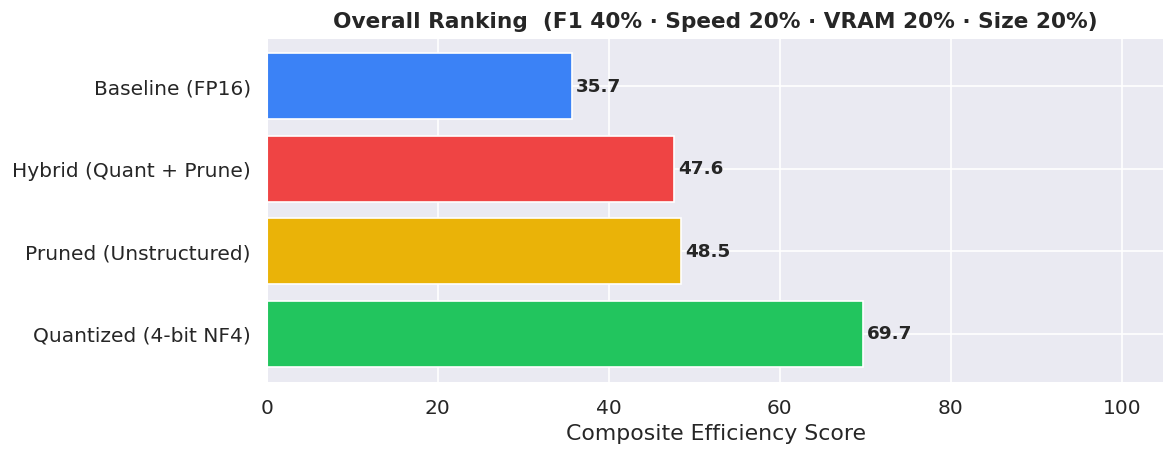

In [15]:
# Composite score = weighted combination of normalized metrics
# Weights: F1 (40%), Speed (20%), VRAM Efficiency (20%), Size Efficiency (20%)
weights = {"F1 Score": 0.4, "Avg Latency (tok/s)": 0.2, "Peak VRAM (GB)": 0.2, "Model Size (GB)": 0.2}
invert_cols = {"Peak VRAM (GB)", "Model Size (GB)"}

score_df = df[["Run Name"]].copy()
for col, w in weights.items():
    vals = df[col].copy()
    rng = vals.max() - vals.min()
    if rng == 0:
        normed = 0.5
    else:
        normed = (vals - vals.min()) / rng
    if col in invert_cols:
        normed = 1 - normed
    score_df[col] = (normed * w * 100).round(1)

score_df["Efficiency Score"] = score_df[list(weights.keys())].sum(axis=1).round(1)
score_df = score_df.sort_values("Efficiency Score", ascending=False)

print("🏆 Composite Efficiency Ranking (higher = better overall):")
display(score_df[["Run Name", "Efficiency Score"]].reset_index(drop=True))

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
colors = [RUN_COLORS.get(r, "#888") for r in score_df["Run Name"]]
bars = ax.barh(score_df["Run Name"], score_df["Efficiency Score"], color=colors, edgecolor="white")
ax.set_xlabel("Composite Efficiency Score")
ax.set_title("Overall Ranking  (F1 40% · Speed 20% · VRAM 20% · Size 20%)")
for bar in bars:
    w = bar.get_width()
    ax.text(w + 0.5, bar.get_y() + bar.get_height()/2, f"{w:.1f}",
            va="center", fontsize=11, fontweight="bold")
ax.set_xlim(0, 105)
plt.tight_layout()
plt.show()

---
## 8 · Correlation Heatmap

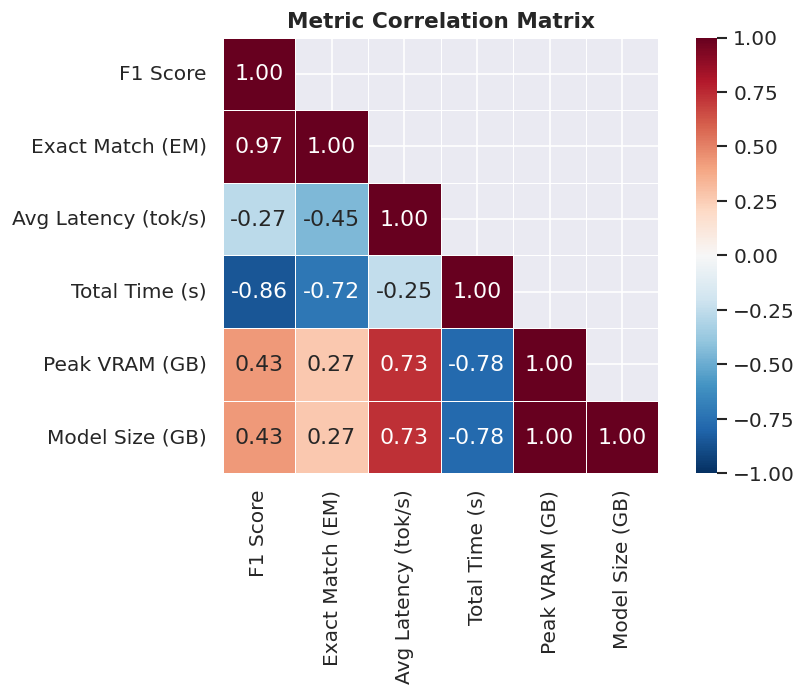

In [16]:
corr_cols = ["F1 Score", "Exact Match (EM)", "Avg Latency (tok/s)",
             "Total Time (s)", "Peak VRAM (GB)", "Model Size (GB)"]
corr = df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="RdBu_r",
            center=0, vmin=-1, vmax=1, square=True, linewidths=0.5, ax=ax)
ax.set_title("Metric Correlation Matrix")
plt.tight_layout()
plt.show()

---
## 9 · Speed vs Accuracy Pareto

/tmp/ipykernel_145736/1480705753.py:23: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/gust/.local/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


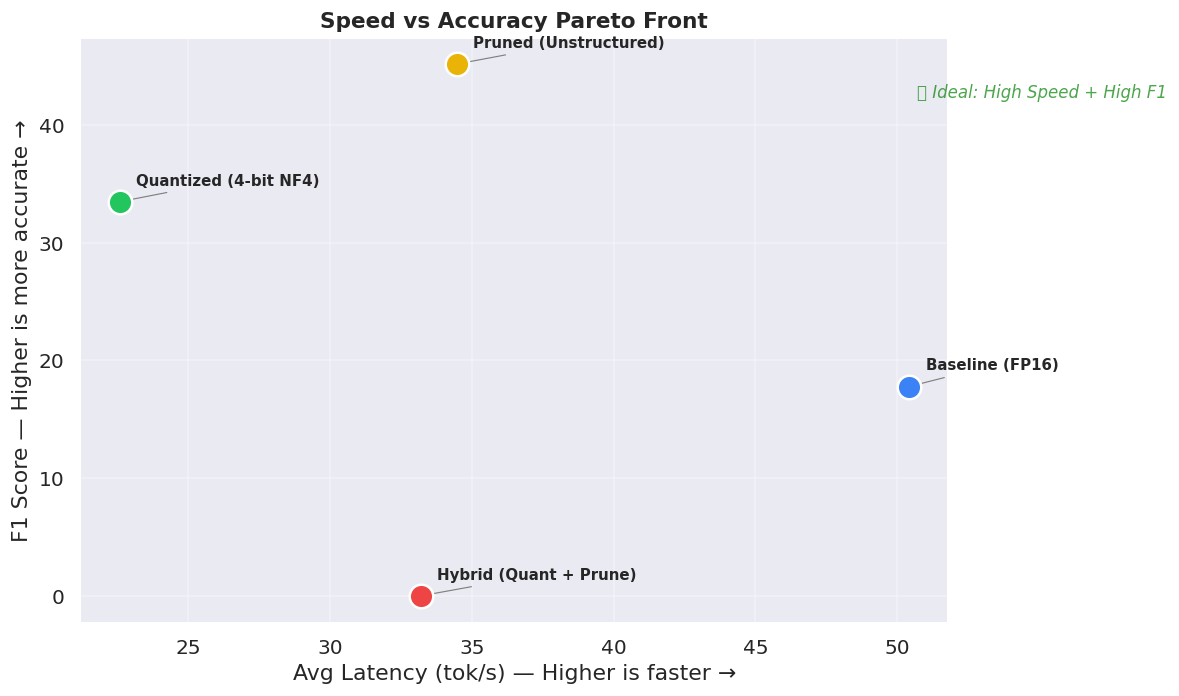

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

for _, row in df.iterrows():
    name = row["Run Name"]
    color = RUN_COLORS.get(name, "#888")
    ax.scatter(row["Avg Latency (tok/s)"], row["F1 Score"],
               s=200, color=color, edgecolors="white", linewidth=1.5, zorder=5)
    ax.annotate(name, (row["Avg Latency (tok/s)"], row["F1 Score"]),
                textcoords="offset points", xytext=(10, 10),
                fontsize=9, fontweight="bold",
                arrowprops=dict(arrowstyle="->", color="gray", lw=0.7))

# Ideal corner
ax.annotate("⭐ Ideal: High Speed + High F1",
            xy=(df["Avg Latency (tok/s)"].max(), df["F1 Score"].max()),
            fontsize=10, fontstyle="italic", color="green", alpha=0.7,
            textcoords="offset points", xytext=(5, -20))

ax.set_xlabel("Avg Latency (tok/s) — Higher is faster →")
ax.set_ylabel("F1 Score — Higher is more accurate →")
ax.set_title("Speed vs Accuracy Pareto Front")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 10 · Full Report Table

In [18]:
report = df.set_index("Run Name").round(2)

def highlight_best(s):
    """Green for best, red for worst."""
    higher_better = ["F1 Score", "Exact Match (EM)", "Avg Latency (tok/s)",
                     "VRAM Savings vs Baseline (%)", "Size Savings vs Baseline (%)",
                     "Speed Ratio vs Baseline"]
    if s.name in higher_better:
        is_best = s == s.max()
    else:
        is_best = s == s.min()
    return ["background-color: #d4edda" if v else "" for v in is_best]

report.style.apply(highlight_best)

,F1 Score,Exact Match (EM),Avg Latency (tok/s),Total Time (s),Peak VRAM (GB),Model Size (GB),VRAM Savings vs Baseline (%),Size Savings vs Baseline (%),F1 Delta vs Baseline,Speed Ratio vs Baseline
Run Name,,,,,,,,,,
Baseline (FP16),17.780000,7.000000,50.420000,45.620000,2.090000,2.050000,0.000000,0.000000,0.000000,1.000000
Quantized (4-bit NF4),33.480000,29.000000,22.590000,68.060000,0.790000,0.700000,62.000000,66.100000,15.700000,0.450000
Pruned (Unstructured),45.170000,39.000000,34.460000,22.640000,2.090000,2.050000,-0.000000,0.000000,27.390000,0.680000
Hybrid (Quant + Prune),0.000000,0.000000,33.200000,151.030000,0.790000,0.700000,62.100000,66.100000,-17.780000,0.660000
